# Imports

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2
import matplotlib 
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0) 
    

In [2]:
LIDAR_PACKAGE_PATH = '/mnt/HFSP_Data/scripts/'
import sys
if LIDAR_PACKAGE_PATH not in sys.path: sys.path.append(LIDAR_PACKAGE_PATH)
import os 



from LIDAR import *
from LIDAR.nnet import generateTrainingSet, egoh5
from scripts.utils import print_d
from kinematics_utils import *
import h5py 
import matplotlib.pyplot as plt
import numpy as np
import glob
from scipy.ndimage import median_filter
import time
%matplotlib notebook

Using TensorFlow backend.
/home/kanishk/miniconda3/envs/dlc1229/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kanishk/miniconda3/envs/dlc1229/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kanishk/miniconda3/envs/dlc1229/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kanis

# Reading Mocap Files

In [3]:
import time

raw_dir ='/mnt/Other_Data/Marshall_Test_Data/Globus_kanishk/mocap_ephys/'

matnames = []
errors = []

matnames = glob.glob(raw_dir+'/diego_mocap*.mat')

# for matfile in matnames:
#     t1 = time.time()
#     print('Loading '+matfile.split('/')[-1])
#     with h5py.File(matfile, 'r') as h5file:
#         try:
#             _ = h5file['markers_preproc']
#             keytofind = 'markers_preproc'
#         except:
#             keytofind = 'mocapstruct_here/markers_preproc' 
#         tslen = h5file[keytofind][list(h5file[keytofind].keys())[0]].shape[1]            
#         print('\t Time series length : %i. Reading time series...\t%0.02f'%(tslen, time.time()-t1))
#         ts = np.zeros((tslen, 60))
#         mat_bad_bool = np.zeros((tslen, 20), dtype=bool) 
#         for bind, bpart in enumerate(h5file[keytofind]):              
#             print('\t\t%i, %s\t%0.02f'%(bind, bpart, time.time()-t1), end='\r')
#             ts[:,bind*3:(bind+1)*3] = h5file[keytofind][bpart][:,:tslen].T
#             mat_bad_bool[np.where(~np.any(np.abs(ts[:,bind*3:(bind+1)*3])>1e-2, axis=1))[0], bind] = True
#     errors.append(np.any(mat_bad_bool, axis=1).sum()*100/tslen)
#     print('%s : %0.02f%% error.'%(matfile.split('/')[-1][:-4], errors[-1]))
#     np.save('mocap_ephys_positions/%s.npy'%(matfile.split('/')[-1][:-4]), ts)

# errors = np.array(errors)


# Reading Saved Raw Data (reading at 60FPS), processing and saving.

In [ ]:
for i,mname in enumerate(matnames):
    print('%i\t%s'%(i,mname.split('/')[-1][:-4]))
    t1 = time.time()
    h5 = np.load('mocap_ephys_positions/%s.npy'%(mname.split('/')[-1][:-4]))[::5]
    print('\t Raw file loaded in %i seconds. Fixing bad indices now.'%(time.time()-t1))

    t = time.time()
    h5[np.isnan(h5)] = 0.0
    goodinds = np.any(np.abs(h5).reshape((-1,20,3))>1e-2, axis=2)
    goodbefore = np.all(goodinds, axis=1).sum()*100/goodinds.shape[0]
    for bpart in range(goodinds.shape[1]):
        badinds = np.where(~goodinds[:,bpart])[0]
        if badinds.shape[0]==0:
            continue
        badinds = np.split(badinds, np.where(np.ediff1d(badinds)!=1)[0]+1)
        fixed = 0
        total = 0

        for inds in badinds:
            total += len(inds)
            if len(inds) < 120:
                if inds[-1]+1 == h5.shape[0]:
                    continue
                fixed += len(inds)
                difftofill = (h5[inds[-1]+1, bpart*3:(bpart+1)*3] - h5[inds[0]-1, bpart*3:(bpart+1)*3])/(len(inds)+1)
                h5[inds, bpart*3:(bpart+1)*3] = h5[inds[0]-1, bpart*3:(bpart+1)*3] + np.multiply(difftofill.reshape((3,1)), np.arange(1,len(inds)+1)).T
#         print('Video %i, bpart %i, fixed %i of %i.'%(i, bpart, fixed, total))
    print('\t Fixed bad indices in %i seconds. Saving processed h5 now.'%(time.time()-t))
    t = time.time()
    #np.save'mocap_ephys_positions/%s_processed.npy'%(mname.split('/')[-1][:-4]), h5)
    print('\t Saved in %i seconds.'%(time.time()-t))
    
    goodinds = np.any(np.abs(h5).reshape((-1,20,3))>1e-2, axis=2)
    goodafter = np.all(goodinds, axis=1).sum()*100/goodinds.shape[0]

    m, s = divmod(h5.shape[0]/60, 60)
    h, m = divmod(m, 60)
    print('Good before, after : %0.01f%%, %0.01f%%  \t length : %i:%i:%0.01f. Time taken to process : %0.01f seconds.'%(goodbefore, goodafter, h, m, s, (time.time()-t1)))
    print('\n')



0	diego_mocap_files_rat_JDM53_day_10


# Reading Processed h5s

In [4]:
h5s = []
goodframe_idxs = []
goods = []
for i,mname in enumerate(matnames):
    print('%i\t%s'%(i,mname.split('/')[-1][:-4]))
    t1 = time.time()

    h5 = np.load('mocap_ephys_positions/%s_processed.npy'%(mname.split('/')[-1][:-4]))
    h5s.append(h5)
    ginds = np.any(np.abs(h5).reshape((-1,20,3))>1e-2, axis=2)
    goodframe_idxs.append(ginds)
    goods.append(np.all(ginds, axis=1).sum()*100/ginds.shape[0])
    
    m, s = divmod(h5.shape[0]/60, 60)
    h, m = divmod(m, 60)
    print('%s \t %0.01f%% good \t length : %i:%i:%0.01f '%(mname.split('/')[-1], goods[-1], h, m, s))
    print('\t Done : %0.1f seconds.'%(time.time()-t1))
    

0	diego_mocap_files_rat_JDM53_day_10
diego_mocap_files_rat_JDM53_day_10.mat 	 61.6% good 	 length : 28:30:0.0 
	 Done : 42.6 seconds.
1	diego_mocap_files_rat_JDM31_day_8
diego_mocap_files_rat_JDM31_day_8.mat 	 74.8% good 	 length : 26:0:0.0 
	 Done : 39.0 seconds.
2	diego_mocap_files_rat_JDM54_day_10
diego_mocap_files_rat_JDM54_day_10.mat 	 79.9% good 	 length : 24:30:0.0 
	 Done : 34.6 seconds.
3	diego_mocap_files_rat_JDM54_day_8
diego_mocap_files_rat_JDM54_day_8.mat 	 73.1% good 	 length : 23:35:53.5 
	 Done : 33.2 seconds.
4	diego_mocap_files_rat_JDM31_day_9
diego_mocap_files_rat_JDM31_day_9.mat 	 81.3% good 	 length : 22:35:13.6 
	 Done : 31.7 seconds.
5	diego_mocap_files_rat_JDM36_day_12
diego_mocap_files_rat_JDM36_day_12.mat 	 71.7% good 	 length : 22:0:0.0 
	 Done : 32.3 seconds.
6	diego_mocap_files_rat_JDM36_day_1
diego_mocap_files_rat_JDM36_day_1.mat 	 80.9% good 	 length : 21:47:6.9 
	 Done : 32.0 seconds.
7	diego_mocap_files_rat_JDM36_day_11
diego_mocap_files_rat_JDM36_day_1

# Egocenter h5s

## Save Ego h5s

In [10]:
# egoh5s = []
for i in range(len(h5s)):
    print(i, end='\r')
    mname = matnames[i]
    h5 = h5s[i]
    try:
        tqdm._instances.clear()
    except:
        pass
    h5 = h5.reshape((-1,20,3))
    h5 = np.append(h5, h5[:,[4,6],:].mean(axis=1).reshape((-1,1,3)), axis=1)
    h5 = h5.reshape((-1,h5.shape[1]*h5.shape[2]))
    
    eh5 = egoh5(h5, ndims=3, bindcenter=19, b1=20, b2=18, silent=True)[:,:57]
    #np.save('mocap_ephys_positions/%s_processed_eh5.npy'%(mname.split('/')[-1][:-4]), eh5)
#     egoh5s.append(eh5)


## Read Ego h5s

In [5]:
egoh5s = []
for i,mname in enumerate(matnames):
    print('%i\t%s'%(i,mname.split('/')[-1][:-4]))
    t1 = time.time()

    eh5 = np.load('mocap_ephys_positions/%s_processed_eh5.npy'%(mname.split('/')[-1][:-4]))
    if np.any(np.isnan(eh5)):
        print('\t has nans.')
    egoh5s.append(eh5)
    print('\t Done : %0.1f seconds.'%(time.time()-t1))
    


0	diego_mocap_files_rat_JDM53_day_10
	 Done : 37.9 seconds.
1	diego_mocap_files_rat_JDM31_day_8
	 Done : 34.5 seconds.
2	diego_mocap_files_rat_JDM54_day_10
	 Done : 32.4 seconds.
3	diego_mocap_files_rat_JDM54_day_8
	 Done : 32.5 seconds.
4	diego_mocap_files_rat_JDM31_day_9
	 Done : 31.3 seconds.
5	diego_mocap_files_rat_JDM36_day_12
	 Done : 30.6 seconds.
6	diego_mocap_files_rat_JDM36_day_1
	 Done : 31.8 seconds.
7	diego_mocap_files_rat_JDM36_day_11
	 Done : 30.3 seconds.
8	diego_mocap_files_rat_JDM36_day_8
	 Done : 30.6 seconds.
9	diego_mocap_files_rat_JDM53_day_7
	 Done : 27.4 seconds.
10	diego_mocap_files_rat_JDM36_day_7
	 Done : 25.1 seconds.
11	diego_mocap_files_rat_JDM53_day_9
	 Done : 25.6 seconds.
12	diego_mocap_files_rat_JDM31_day_13
	 Done : 24.5 seconds.
13	diego_mocap_files_rat_JDM54_day_6
	 Done : 23.6 seconds.
14	diego_mocap_files_rat_JDM54_day_7
	 Done : 23.4 seconds.
15	diego_mocap_files_rat_JDM54_day_15
	 Done : 23.4 seconds.
16	diego_mocap_files_rat_JDM54_day_16
	 Done

## Check Ego h5s for nans

In [6]:
# for i,mname in enumerate(matnames):
#     print('%i\t%s'%(i,mname.split('/')[-1][:-4]))
#     t1 = time.time()

#     eh5 = np.load('mocap_ephys_positions/%s_processed_eh5.npy'%(mname.split('/')[-1][:-4]))
#     eh5[np.isnan(eh5)] = 0.0
    #np.save('mocap_ephys_positions/%s_processed_eh5.npy'%(mname.split('/')[-1][:-4]), eh5)
    
#     badinds = np.isnan(eh5)
#     if np.any(badinds):
#         print('\t\t has nans. %i/%i'%(np.sum(np.any(badinds, axis=1)), eh5.shape[0]))
#         h5 = np.load('mocap_ephys_positions/%s_processed.npy'%(mname.split('/')[-1][:-4]))
#         badindsh5 = np.isnan(h5)
#         print('\t\t Processed has nans. %i/%i'%(np.sum(np.any(badindsh5, axis=1)), h5.shape[0]))
#     print('\t Done : %0.1f seconds.'%(time.time()-t1))



0	diego_mocap_files_rat_JDM53_day_10


KeyboardInterrupt: 

In [7]:
bpartnames = ['ArmL', 'ArmR', 'ElbowL', 'ElbowR', 'HeadB', 'HeadF', 'HeadL', 'HipL', 
              'HipR', 'KneeL', 'KneeR', 'Offset1', 'Offset2', 'ShinL', 'ShinR', 'ShoulderL', 
              'ShoulderR', 'SpineF', 'SpineL', 'SpineM']

connections = [[5, 4, 6], [4,17,19,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]
connections2 = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]


# Check poses

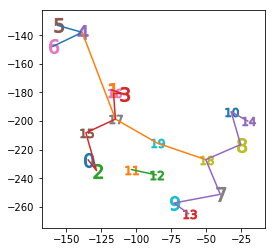

In [9]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(4,4))
vind = 18
t = 100000

for i in range(20):
    ax.scatter(h5s[vind][t,3*i],h5s[vind][t,3*i+1],marker='$'+str(i)+'$',s=200)
for conn in connections:
    ax.plot(h5s[vind][t].reshape((20,3))[conn,0], h5s[vind][t].reshape((20,3))[conn,1])
    

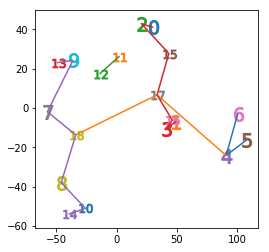

In [10]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(4,4))
vind = 18
t = 100000

for i in range(19):
    ax.scatter(egoh5s[vind][t,3*i], egoh5s[vind][t,3*i+1],marker='$'+str(i)+'$',s=200)
for conn in connections2:
    ax.plot(egoh5s[vind][t].reshape((19,3))[conn,0], egoh5s[vind][t].reshape((19,3))[conn,1])
    

<IPython.core.display.Javascript object>


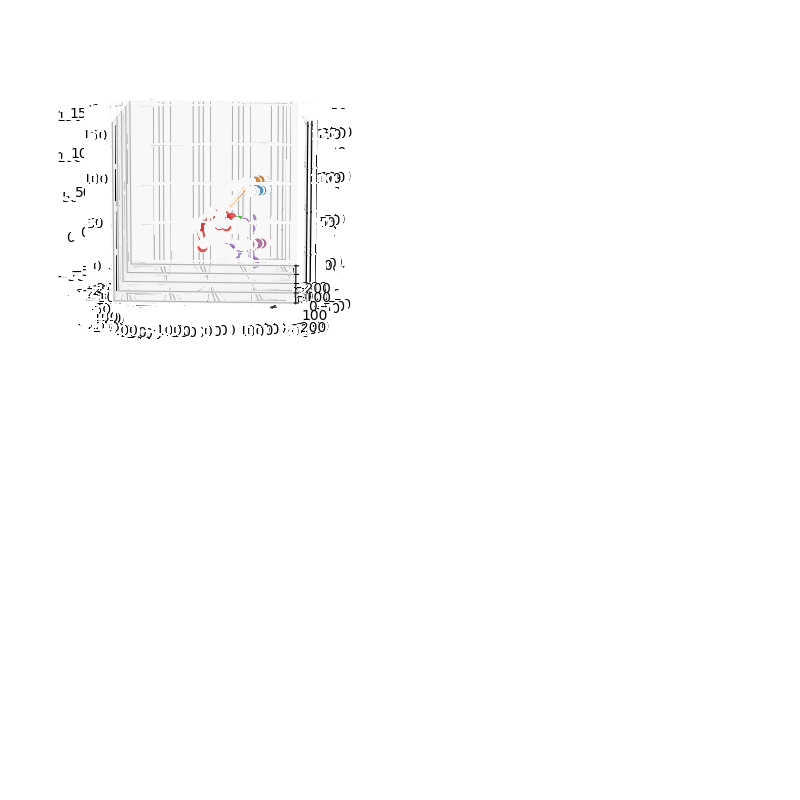

KeyboardInterrupt: 

In [11]:
vind = 0
rawh5 = h5s[0].reshape((-1,20,3))
badinds = np.all(goodframe_idxs[vind], axis=1)

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111, projection='3d')
# fig.subplots_adjust(0,0,1,1,0,0)
plt.ion()
fig.show()
fig.canvas.draw()
count = 0
for t in np.setdiff1d(np.arange(rawh5.shape[0]), np.where(np.all(goodframe_idxs[vind], axis=1))[0]):
    ax1.clear()
    for conn in connections:
        ax1.plot(rawh5[t,conn,0],rawh5[t,conn,1], rawh5[t,conn,2], 'o-', alpha=0.7)
    ax1.set_xlim([-200, 200])
    ax1.set_ylim([-200, 200])
    ax1.set_zlim([-50, 150])
    ax1.view_init(10, count)
    count += 1
#     ax1.grid('off')
#     ax1.axis('off')
    if np.all(goodframe_idxs[vind][t]):
        ax.set_title('Good %i'%t, color='royalblue')
    else:
        ax.set_title('Good %i'%t, color='firebrick')

    fig.canvas.draw()        

<IPython.core.display.Javascript object>


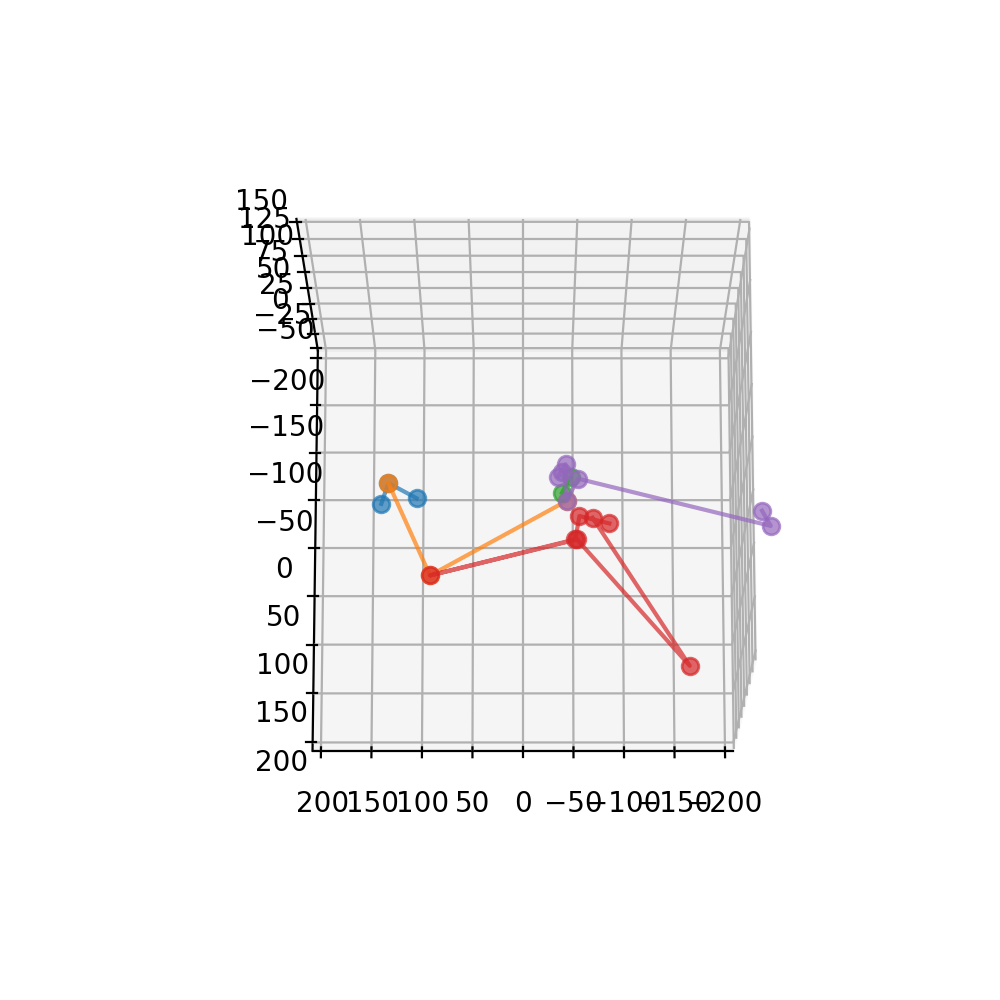

NameError: name 'inds' is not defined

In [13]:
rawh5 = egoh5s[vind].reshape((-1,19,3))

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111, projection='3d')
# fig.subplots_adjust(0,0,1,1,0,0)
plt.ion()
fig.show()
fig.canvas.draw()

for t in np.arange(0,rawh5.shape[0],50):#range(0,10000,200)        
    ax1.clear()
    for conn in connections2:
        ax1.plot(rawh5[t,conn,0],rawh5[t,conn,1], rawh5[t,conn,2], 'o-', alpha=0.7)
    ax1.set_xlim([-200, 200])
    ax1.set_ylim([-200, 200])
    ax1.set_zlim([-50, 150])
    ax1.view_init(75, 90)
#     ax1.grid('off')
#     ax1.axis('off')
    if t in inds:
        ax.set_title('Fixed %i'%t)
    else:
        ax.set_title('Original %i'%t)

    fig.canvas.draw()        

# Data Summary

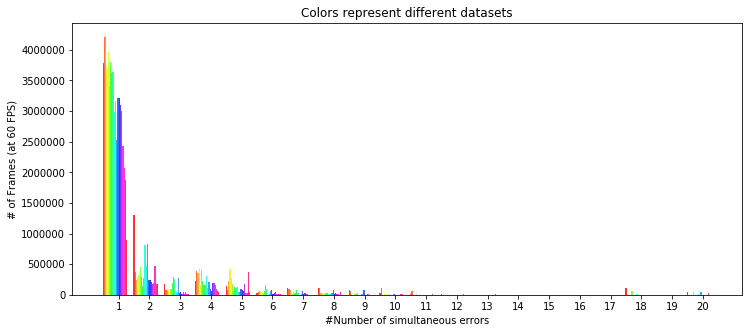

In [11]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,5))


barWidth = 0.04
colors = matplotlib.cm.hsv(np.linspace(0,1,len(h5s)))

for j,goodinds in enumerate(goodframe_idxs):
    counts = np.histogram(np.sum(~goodinds, axis=1), bins = np.arange(21), density=False)
    ax.bar(np.arange(1,21)-0.5+j*barWidth, counts[0], color=colors[j], width=barWidth, alpha=0.8)
ax.set_xlabel('#Number of simultaneous errors')
ax.set_ylabel('# of Frames (at 60 FPS)')
ax.set_title('Colors represent different datasets')
# ax.set_yscale('log')
_ = ax.set_xticks(np.arange(1, 21, 1.0).astype('int'))


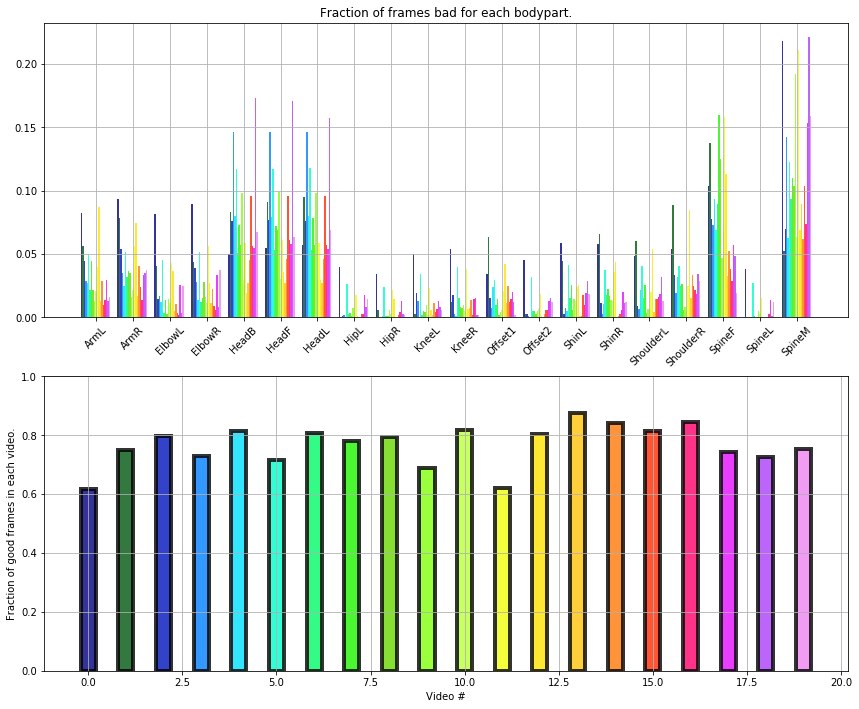

In [12]:
colors = matplotlib.cm.gist_ncar(np.linspace(0,0.9,len(h5s)))
%matplotlib inline

fig, (ax, ax2) = plt.subplots(2,1,figsize=(12.0,10.0), num=2)
fig.subplots_adjust(0.05,0.05,0.98,0.95,0,0.2)
barWidth = 0.04

fracgood = []
for j,h5 in enumerate(h5s):
    goodinds = goodframe_idxs[j]
    h5 = h5
    cnot1 = (np.sum(~goodinds, axis=0)/h5.shape[0])
    ax.bar(np.arange(20)+j*barWidth, cnot1, color=colors[j], width=barWidth, alpha=0.8)
    fracgood.append(np.all(goodinds, axis=1).sum()/h5.shape[0])

ax.set_xticks(np.arange(20)+barWidth*len(h5s)/2.0)
ax.set_xticklabels(bpartnames, rotation=45)
ax.set_title("Fraction of frames bad for each bodypart.")
# ax.set_ylim([0.7,1.02])
ax.grid()
ax2.bar(np.arange(len(h5s)), fracgood, color=colors, width=0.4, linewidth=4.0, edgecolor='k', alpha=0.8)
ax2.set_xlabel('Video #')
ax2.set_ylabel('Fraction of good frames in each video.')
ax2.set_ylim([0.,1])
ax2.grid()



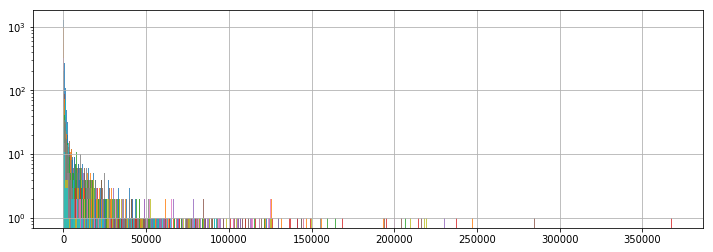

In [13]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12.0,4.0))
goodsplits = []
for j,h5 in enumerate(h5s):
    goodinds = goodframe_idxs[j]
    goodinds = np.where(np.all(goodinds, axis=1))[0]
    splits = np.array(np.split(goodinds, np.where(np.ediff1d(goodinds)!=1)[0]+1))
    split_lens = [len(split) for split in splits]
    goodsplits.append([split for split in splits if len(split)>30000 ])
    ax.hist(split_lens, bins=np.arange(0,np.max(split_lens)+500, step=500), alpha=0.8, label=str(j))
_ = ax.set_yscale('log')
# ax.legend()

ax.grid()

Total frames in the box : 12429155


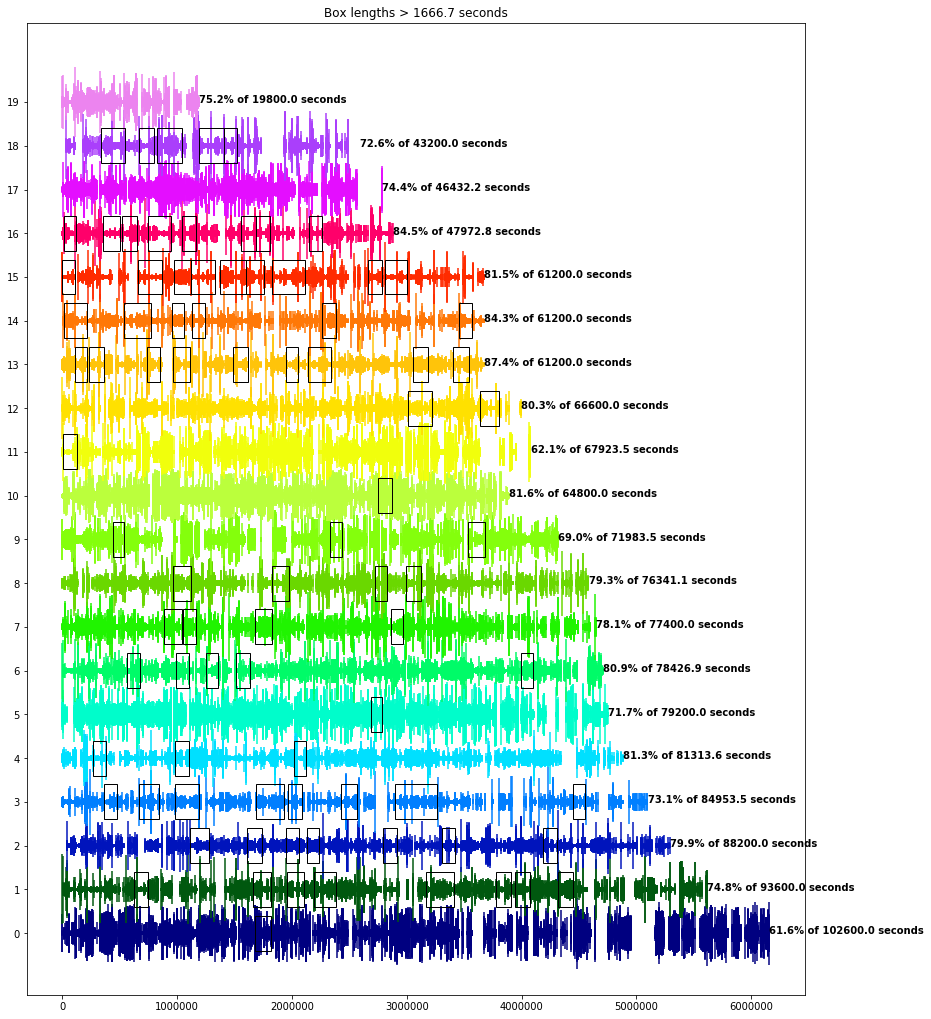

In [14]:
%matplotlib inline
import matplotlib
min_length = 100000
goodinds_thres = []

colorslist = matplotlib.cm.gist_ncar(np.linspace(0,0.9,len(h5s)))
# np.random.shuffle(colors)
fig, ax = plt.subplots(figsize=(12.0, 15.0))
fig.subplots_adjust(0.05,0.05,0.95,0.95,0,0)
for j,h5 in enumerate(h5s):
    print('Loading....%0.2f%%'%(j*100/len(h5s)), end='\r')
    h5 = h5
    goodinds = goodframe_idxs[j]
    goodinds = np.where(np.all(goodinds, axis=1))[0]
    goodinds = np.array(np.split(goodinds, np.where(np.ediff1d(goodinds)!=1)[0]+1))
    vel = np.linalg.norm(np.diff(np.mean(h5.reshape((h5.shape[0], int(h5.shape[1]/3), 3)), axis=1), axis=0), axis=1)
    vel = np.concatenate(([vel[0]], vel), axis=0)
    # vel = np.clip(vel, 0, 1)/1.0
    for inds in goodinds:   
        ax.scatter(inds, np.ones_like(inds)*j, color=colorslist[j], marker='|', s=10+vel[inds]*5000/vel.max())
    ax.text(h5.shape[0]+2000, j-0.02, '%0.1f%% of %0.1f seconds'%(fracgood[j]*100, h5.shape[0]/60.0), fontweight='bold', color='k')
    for g in goodinds:
        if g.shape[0]>min_length:
            rect = matplotlib.patches.Rectangle((g[0], j-0.4),g[-1]-g[0],0.8,linewidth=1,edgecolor='k',facecolor='none')
            ax.add_patch(rect)
    goodinds_thres.append([g for g in goodinds if g.shape[0]>min_length])
    print('%i total frames are %i'%(j, np.sum([len(g) for g in goodinds if g.shape[0]>min_length])), end='\r')
ax.set_yticks(np.arange(len(h5s)))
ax.set_title("Box lengths > %0.1f seconds"%(min_length/60.0))
print('Total frames in the box : %i'% np.sum([g.shape[0] for ginds in goodinds_thres for g in ginds]))

In [15]:
lengthlist = [[int(len(g)/3600) for g in ginds] for ginds in goodinds_thres]
print('Length of good segments in mins :')
lengthlist

Length of good segments in mins :


[[39],
 [33, 43, 40, 53, 68, 34, 36, 34],
 [44, 35, 30, 29, 33, 32, 32],
 [31, 46, 59, 66, 32, 37, 102, 28],
 [31, 36, 29],
 [28],
 [31, 33, 30, 32, 28],
 [42, 31, 43, 29],
 [41, 40, 29, 34],
 [28, 29, 39],
 [34],
 [33],
 [57, 45],
 [29, 36, 30, 41, 38, 28, 54, 35, 39],
 [57, 63, 29, 31, 34, 29],
 [30, 56, 39, 60, 61, 44, 79, 33, 53],
 [28, 40, 36, 55, 34, 34, 34, 31],
 [],
 [58, 34, 60, 60, 31],
 []]

# Save these segments for VAE

In [66]:
outpath = '/mnt/HFSP_Data/scripts/Marshall_Data/VAE_RNN/mocap_clean_eh5/%s'
for mname, eh5, ginds in zip(matnames, egoh5s, goodinds_thres):
    if not ginds:
        continue
    glens = [len(g)/3600 for g in ginds]
    g = ginds[np.argmax(glens)]

    mname = mname.split('/')[-1][22:-4]+'_%i_%i.npy'%(g[0], g[-1])
    print(mname)
    
    np.save(outpath%mname, eh5[g[0]:g[-1]])
    


JDM53_day_10_1677209_1818234.npy
JDM31_day_8_3167681_3414878.npy
JDM54_day_10_1116000_1275679.npy
JDM54_day_8_2893385_3261208.npy
JDM31_day_9_977147_1106996.npy
JDM36_day_12_2684503_2787788.npy
JDM36_day_1_985842_1104791.npy
JDM36_day_11_1674564_1829602.npy
JDM36_day_8_967998_1117643.npy
JDM53_day_7_3535012_3678521.npy
JDM36_day_7_2748459_2871235.npy
JDM53_day_9_4000_126306.npy
JDM31_day_13_3013484_3220194.npy
JDM54_day_6_2141573_2336626.npy
JDM54_day_7_538441_768739.npy
JDM54_day_15_1826406_2111160.npy
JDM54_day_16_743944_944194.npy
JDM54_day_17_822468_1041941.npy
